## Tunagem de Hiperparametros

In [1]:
# importação via github 
import pandas as pd
url = 'https://raw.githubusercontent.com/gitflai/DDS/main/Datasets/insurance.csv'
dados = pd.read_csv(url)
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
#pre processamento de dados
#variaveis continuas foram normalizadas
dados['smoker'] = dados['smoker'].map({'yes': 1, 'no': 0})
dados['charges'] = dados['charges']/max(dados['charges'])
dados['age'] = dados['age']/max(dados['age'])
dados['bmi'] = dados['bmi']/max(dados['bmi'])
dados = pd.get_dummies(dados, columns = ['sex', 'children', 'region'], drop_first = True)
dados.head()

,age,bmi,smoker,charges,sex_male,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest
0,0.296875,0.525127,1,0.264777,0,0,0,0,0,0,0,0,1
1,0.281250,0.635611,0,0.027059,1,1,0,0,0,0,0,1,0
2,0.437500,0.621118,0,0.069773,1,0,0,1,0,0,0,1,0
3,0.515625,0.427348,0,0.344744,1,0,0,0,0,0,1,0,0
4,0.500000,0.543572,0,0.060637,1,0,0,0,0,0,1,0,0


In [3]:
#separacao de variaveis preditoras e variavel resposta

X = dados.drop('smoker', axis = 1)
y = dados['smoker']

##Tunagem de Hiperparametros 

Tunagem de Hiperparametros nada mais é do que encontrar qual a melhor combinação de valores que passamos aos algoritmos no momento de seu treinamento. Alguns modelos tem poucos hiperparametros que se deseja tunar, outros tem muitos. 

Para fazer essa checagem, testa-se atraves de um metodo de validação selecionado o desempenho de cada possivel combinação de hiperparametros apresentado. 

Logo se ve que se necessita de bastante poder computacional para realizar tal checagem. 

In [4]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [5]:
np.arange(1, 50, 2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

In [6]:
modelo = KNeighborsClassifier()

parametros = {'n_neighbors': np.arange(1, 50, 2)}

grid_search = GridSearchCV(modelo, param_grid = parametros,
                           scoring = 'accuracy',
                           cv = validacao,
                           verbose = 1,
                           n_jobs = -1)

grid_search.fit(X, y)

Fitting 30 folds for each of 25 candidates, totalling 750 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             scoring='accuracy', verbose=1)

In [7]:
grid_search.best_score_

0.9322279579545878

In [8]:
grid_search.best_params_

{'n_neighbors': 1}

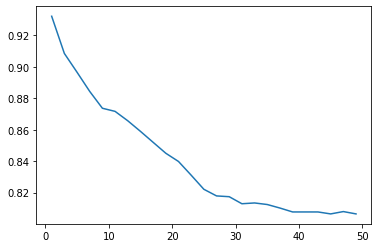

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, 50, 2), grid_search.cv_results_['mean_test_score']);

In [10]:
random_search = RandomizedSearchCV(modelo, param_distributions= parametros,
                                   scoring = 'accuracy',  
                                   cv = validacao,
                                   verbose =1,
                                   n_iter = 10,
                                   n_jobs =-1)

random_search.fit(X, y)


Fitting 30 folds for each of 10 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
                   estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
                   scoring='accuracy', verbose=1)

In [11]:
random_search.best_score_

0.9314760782553398

In [12]:
random_search.cv_results_['mean_test_score']

array([0.82461377, 0.81912991, 0.93147608, 0.89511839, 0.80842217,
       0.87219541, 0.86024015, 0.80817342, 0.81613923, 0.81015973])

In [14]:
random_search.best_score_

0.9314760782553398

In [16]:
def Tunagem(modelo, treino, targets, parametros, tipo = 'grid', metrica = 'accuracy', n_iter = 20):
    validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats= 3)

    if tipo == 'grid':
        search = GridSearchCV(modelo, param_grid = parametros,
                              scoring = metrica, cv = validacao,
                              verbose = 1, n_jobs = -1)
    elif tipo == 'random':
        search = RandomizedSearchCV(modelo, param_distributions= parametros,
                                    scoring = metrica, cv = validacao,
                                    n_iter = n_iter, verbose = 1, n_jobs = -1)
        
    else:
        print('entrada invalida no argumento "tipo"')

    search.fit(treino, targets) #= a X,y

    melhor = search.best_estimator_

    print('\nAcuracia: {:.4f}'.format(search.best_score_))
    print('Melhores parametros: {}\n'.format(search.best_params_))

    return melhor 

    


In [17]:
parametros = { 'n_neighbors': np.arange(1, 50, 2)}

modelo = KNeighborsClassifier()

knn = Tunagem(modelo, X, y, parametros, tipo = 'random')

Fitting 30 folds for each of 20 candidates, totalling 600 fits

Acuracia: 0.9365
Melhores parametros: {'n_neighbors': 1}



In [18]:
np.arange(2, 21, 2)

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [19]:
parametros = {
              'max_depth': np.arange(1, 11),
              'min_samples_split': np.arange(2, 21, 2),
              'min_samples_leaf': np.arange(1,11),
              }

modelo = DecisionTreeClassifier()

arvore = Tunagem(modelo, X, y, parametros, tipo = 'random', n_iter = 50)

arvore


Fitting 30 folds for each of 50 candidates, totalling 1500 fits

Acuracia: 0.9634
Melhores parametros: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}



DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=4)

In [20]:
parametros = {
              'n_estimators': [50,100,150],
              'max_features': [2,3,4,5,6],
              'bootstrap':[True, False],
              'max_depth':[2, 4, 6, 8, 10],
              'min_samples_split':[2, 5, 10],
              'min_samples_leaf': [1, 3, 5]
              }

modelo = RandomForestClassifier()

rf = Tunagem(modelo, X, y, parametros, tipo = 'random')

rf

Fitting 30 folds for each of 20 candidates, totalling 600 fits

Acuracia: 0.9669
Melhores parametros: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10, 'bootstrap': False}



RandomForestClassifier(bootstrap=False, max_depth=10, max_features=6,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=150)